In [2]:
import pandas as pd
import os


############################################# Utilised datasets
#These are all 'event' factors, they are the same for every accident.
# Accident_location.csv:
# Accident.csv:
# Atmospheric_cond.csv:
# Node.csv:
# Road_surface_cond.csv:


############################################# Mappings
# These are simply value mappings for the categorical data, just for reference.

node_type_from_id = {
    "I": "Intersection",
    "N": "Non-Intersection",
    "O": "Off Road",
    "U": "Unknown"
}

light_condition_from_id = {
    1: "Day",
    2: "Dusk/dawn",
    3: "Dark street lights on",
    4: "Dark street lights off",
    5: "Dark no street lights",
    6: "Dark street lights unknown",
    9: "Unknown"
}

road_geometry_from_id = {
    1: "Cross intersection",
    2: "T Intersection",
    3: "Y Intersection",
    4: "Multiple intersections",
    5: "Not at intersection",
    6: "Dead end",
    7: "Road closure",
    8: "Private property",
    9: "Unknown"
}

atmospheric_cond_from_id = {
    1: "Clear",
    2: "Raining",
    3: "Snowing",
    4: "Fog",
    5: "Smoke",
    6: "Dust",
    7: "Strong winds",
    9: "Not known"
}

surface_cond_from_id = {
    1: "Dry",
    2: "Wet",
    3: "Muddy",
    4: "Snowy",
    5: "Icy",
    9: "Unknown"
}

day_from_id = {
    1: "Sunday",
    2: "Monday",
    3: "Tuesday",
    4: "Wednesday",
    5: "Thursday",
    6: "Friday",
    7: "Saturday"
}


DATA_DIR = "data"



def event_preprocess():

    #181055 rows/accidents, keeping only important columns.
    accident_df = pd.read_csv("/Users/armaansidhu/Documents/Uni/year-2/EODP/code/proj_2/datasets/accident.csv")
    COLS_TO_KEEP = ["ACCIDENT_NO", "ACCIDENT_TIME", "DAY_OF_WEEK", "LIGHT_CONDITION", "ROAD_GEOMETRY", "SPEED_ZONE", "SEVERITY"]
    accident_df = accident_df[COLS_TO_KEEP]


    #181055 rows/accidents, again keeping only important columns.
    accident_location_df = pd.read_csv("/Users/armaansidhu/Documents/Uni/year-2/EODP/code/proj_2/datasets/accident_location.csv")
    COLS_TO_KEEP = ["ACCIDENT_NO", "ROAD_TYPE"]
    accident_location_df = accident_location_df[COLS_TO_KEEP]


    #183405 rows/accidents before pre-processing. This is because the same accident can have multiple atmospheric conditions. Fixed now to 181055 rows, with ATMOSPH_COND now containing a list of atmospheric conditions for each accident.
    atmospheric_cond_df = pd.read_csv("/Users/armaansidhu/Documents/Uni/year-2/EODP/code/proj_2/datasets/atmospheric_cond.csv")
    filtered_atmospheric_cond_df = atmospheric_cond_df.groupby('ACCIDENT_NO')['ATMOSPH_COND'].agg(list).reset_index()



    #182062 rows/accidents for the same reason as the previous, fixed to be 181055 rows.
    road_surface_cond_df = pd.read_csv("/Users/armaansidhu/Documents/Uni/year-2/EODP/code/proj_2/datasets/road_surface_cond.csv")
    filtered_road_surface_cond_df = road_surface_cond_df.groupby('ACCIDENT_NO')['SURFACE_COND'].agg(list).reset_index()


    #183830 rows/accidents for the same reason as the previous ones. Its a little weird though, they are saying
    #the same accident can have multiple locations which seems kind of stupid. 
    #NOTE: for now, I literally just take the first instance of location for each accident.
    node_df = pd.read_csv("/Users/armaansidhu/Documents/Uni/year-2/EODP/code/proj_2/datasets/node.csv")
    columns_to_keep = ['ACCIDENT_NO', 'NODE_TYPE', 'DEG_URBAN_NAME', 'POSTCODE_CRASH']
    filtered_node_df = node_df[columns_to_keep]


    #Now we get 180970 rows which is less than the 183405 accidents. This means there are 85 accidents that are in all of the other dataframes but not in the node dataframe. I just remove these from the total dataframe for now, giving us a total of 180970 rows.
    filtered_node_df = filtered_node_df.drop_duplicates(subset='ACCIDENT_NO')


    #We copy from the node df that doesn't contain those 85 accidents, so all operations will leave out the bad 85 accidents.
    event_df = filtered_node_df.copy()
    event_df = event_df.merge(accident_df, on='ACCIDENT_NO', how='inner')
    event_df = event_df.merge(accident_location_df, on='ACCIDENT_NO', how='inner')
    event_df = event_df.merge(filtered_atmospheric_cond_df, on='ACCIDENT_NO', how='inner')
    event_df = event_df.merge(filtered_road_surface_cond_df, on='ACCIDENT_NO', how='inner')

    #Move the severity column to the end just for clarity:
    event_df = event_df[[col for col in event_df.columns if col != 'SEVERITY'] + ['SEVERITY']]

    #We have 180970 rows and 13 columns.
    event_df.to_csv("event_df.csv", index=False)

    return event_df


if __name__ == "__main__":  
    event_df = event_preprocess()

event_df.head(10)

,ACCIDENT_NO,NODE_TYPE,DEG_URBAN_NAME,POSTCODE_CRASH,ACCIDENT_TIME,DAY_OF_WEEK,LIGHT_CONDITION,ROAD_GEOMETRY,SPEED_ZONE,ROAD_TYPE,ATMOSPH_COND,SURFACE_COND,SEVERITY
0,T20120000009,N,RURAL_VICTORIA,3981,02:25:00,1,5,5,100,ROAD,[1],[1],3
1,T20120000012,N,MELB_URBAN,3170,02:00:00,1,3,1,80,ROAD,[1],[1],2
2,T20120000013,I,MELB_URBAN,3169,03:35:00,1,3,2,60,ROAD,[1],[1],2
3,T20120000018,I,RURAL_VICTORIA,3505,05:15:00,1,5,1,100,HIGHWAY,[1],[1],3
4,T20120000021,N,MELB_URBAN,3942,07:30:00,1,1,5,50,ROAD,[1],[1],3
5,T20120000028,N,RURAL_VICTORIA,3719,04:00:00,1,5,2,100,ROAD,[1],[1],2
6,T20120000032,I,MELB_URBAN,3206,00:55:00,1,3,2,50,LANE,[1],[1],3
7,T20120000043,N,MELB_URBAN,3977,00:45:00,1,5,2,80,HIGHWAY,[1],[1],2
8,T20120000044,I,MELB_URBAN,3160,16:25:00,1,1,2,60,ROAD,[1],[1],2
9,T20120000046,I,MELB_URBAN,3940,16:25:00,1,1,2,60,ROAD,[1],[1],3


Imputing missing values in the data. First i found what was missing then used that information to fillna 

In [3]:
event_df.isnull().sum()
event_df['DEG_URBAN_NAME'] = event_df['DEG_URBAN_NAME'].fillna('Unknown')
event_df['ROAD_TYPE'] = event_df['ROAD_TYPE'].fillna('Unknown')
event_df.isnull().sum()

ACCIDENT_NO        0
NODE_TYPE          0
DEG_URBAN_NAME     0
POSTCODE_CRASH     0
ACCIDENT_TIME      0
DAY_OF_WEEK        0
LIGHT_CONDITION    0
ROAD_GEOMETRY      0
SPEED_ZONE         0
ROAD_TYPE          0
ATMOSPH_COND       0
SURFACE_COND       0
SEVERITY           0
dtype: int64

In [4]:
def bin_time_of_day(time_str):
    hour = int(time_str.split(':')[0])
    if 0 <= hour < 6:
        return "Late_Night"
    elif 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    else:
        return "Evening"

# Apply binning
event_df["TIME_BIN"] = event_df["ACCIDENT_TIME"].apply(bin_time_of_day)
event_df.drop(columns=["ACCIDENT_TIME"], inplace=True)
event_df.drop(columns=["ACCIDENT_NO"], inplace=True)
event_df.drop(columns=["POSTCODE_CRASH"], inplace=True)
event_df = pd.get_dummies(event_df, columns=["TIME_BIN"], prefix="TIME")


time_bin_cols = [col for col in event_df.columns if col.startswith("TIME_")]
event_df[time_bin_cols] = event_df[time_bin_cols].astype(int)
event_df.head(10)


,NODE_TYPE,DEG_URBAN_NAME,DAY_OF_WEEK,LIGHT_CONDITION,ROAD_GEOMETRY,SPEED_ZONE,ROAD_TYPE,ATMOSPH_COND,SURFACE_COND,SEVERITY,TIME_Afternoon,TIME_Evening,TIME_Late_Night,TIME_Morning
0,N,RURAL_VICTORIA,1,5,5,100,ROAD,[1],[1],3,0,0,1,0
1,N,MELB_URBAN,1,3,1,80,ROAD,[1],[1],2,0,0,1,0
2,I,MELB_URBAN,1,3,2,60,ROAD,[1],[1],2,0,0,1,0
3,I,RURAL_VICTORIA,1,5,1,100,HIGHWAY,[1],[1],3,0,0,1,0
4,N,MELB_URBAN,1,1,5,50,ROAD,[1],[1],3,0,0,0,1
5,N,RURAL_VICTORIA,1,5,2,100,ROAD,[1],[1],2,0,0,1,0
6,I,MELB_URBAN,1,3,2,50,LANE,[1],[1],3,0,0,1,0
7,N,MELB_URBAN,1,5,2,80,HIGHWAY,[1],[1],2,0,0,1,0
8,I,MELB_URBAN,1,1,2,60,ROAD,[1],[1],2,1,0,0,0
9,I,MELB_URBAN,1,1,2,60,ROAD,[1],[1],3,1,0,0,0


Encoding the values


In [ ]:
df_onehot = event_df.copy()
df_onehot["NODE_TYPE"] = df_onehot["NODE_TYPE"].map(node_type_from_id)
df_onehot["LIGHT_CONDITION"] = df_onehot["LIGHT_CONDITION"].map(light_condition_from_id)
df_onehot["ROAD_GEOMETRY"] = df_onehot["ROAD_GEOMETRY"].map(road_geometry_from_id)

one_hot_cols = ["NODE_TYPE", "DEG_URBAN_NAME", "ROAD_TYPE", "LIGHT_CONDITION", "ROAD_GEOMETRY"]

df_onehot_encoded = pd.get_dummies(df_onehot, columns=one_hot_cols, prefix_sep="_")
encoded_cols = [col for col in df_onehot_encoded.columns if any(base + "_" in col for base in one_hot_cols)]
df_onehot_encoded[encoded_cols] = df_onehot_encoded[encoded_cols].astype(int)

unique_atmosph = sorted({val for sublist in df_onehot_encoded["ATMOSPH_COND"] for val in sublist})
unique_surface = sorted({val for sublist in df_onehot_encoded["SURFACE_COND"] for val in sublist})

# 2. Create binary columns
for val in unique_atmosph:
    df_onehot_encoded[f"ATMOSPH_COND_{val}"] = df_onehot_encoded["ATMOSPH_COND"].apply(lambda x: int(val in x))

for val in unique_surface:
    df_onehot_encoded[f"SURFACE_COND_{val}"] = df_onehot_encoded["SURFACE_COND"].apply(lambda x: int(val in x))

# 3. Drop original list columns
df_onehot_encoded.drop(columns=["ATMOSPH_COND", "SURFACE_COND"], inplace=True)

df_onehot_encoded.head(10)

Scaling

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Use the actual DataFrame name
X = df_onehot_encoded.drop(columns=["SEVERITY"], errors="ignore")
y = df_onehot_encoded["SEVERITY"]

# Scale numeric features only
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame with same column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

X_df = pd.DataFrame(X_scaled, columns=X.columns)

vif_data = pd.DataFrame()
vif_data["feature"] = X_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

# Show features with high multicollinearity
print(vif_data.sort_values(by="VIF", ascending=False).head(10))

pca = PCA(n_components=0.95)  # retain 95% variance
X_pca = pca.fit_transform(X_scaled)

                feature           VIF
83   ROAD_TYPE_STREET S  7.345320e+10
48    ROAD_TYPE_GATEWAY  4.634263e+10
49      ROAD_TYPE_GLADE  3.928232e+10
20        ROAD_TYPE_ALT  3.544565e+10
43  ROAD_TYPE_FIREBREAK  3.211455e+10
41   ROAD_TYPE_ENTRANCE  2.692832e+10
64       ROAD_TYPE_PASS  1.975922e+10
50       ROAD_TYPE_GLEN  1.853608e+10
51     ROAD_TYPE_GRANGE  1.610156e+10
71       ROAD_TYPE_QUAY  1.549122e+10


Next KNN will be applied

In [23]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.2, stratify=y, random_state=42
)
print(y.value_counts(normalize=True))  # Show class proportions

SEVERITY
3    0.623312
2    0.360205
1    0.016483
Name: proportion, dtype: float64


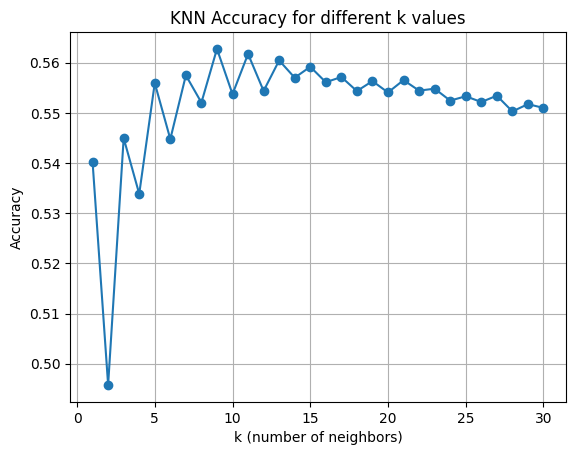

AttributeError: 'list' object has no attribute 'max'

In [28]:
from sklearn.metrics import accuracy_score

k_values = range(1, 10)
accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k, weights='distance')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot
import matplotlib.pyplot as plt
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('k (number of neighbors)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for different k values')
plt.grid(True)
plt.show()



              precision    recall  f1-score   support

       Minor       0.02      0.02      0.02       589
     Serious       0.41      0.35      0.38     12867
       Fatal       0.65      0.70      0.67     22265

    accuracy                           0.56     35721
   macro avg       0.36      0.36      0.36     35721
weighted avg       0.55      0.56      0.56     35721

Accuracy 0.5627502029618432


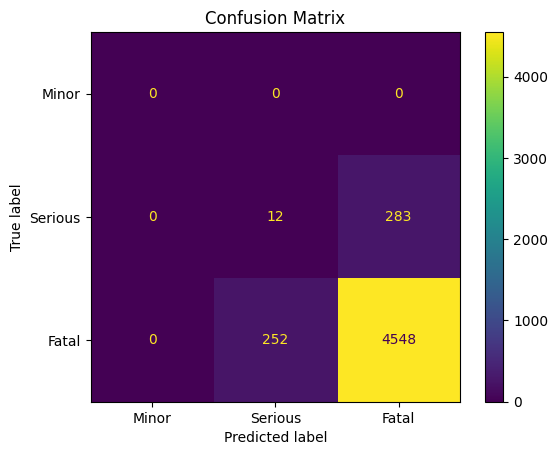

In [31]:


knn = KNeighborsClassifier(n_neighbors=9, weights='distance')  # You can tune this later
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

# Print metrics
print(classification_report(
    y_test,
    y_pred,
    target_names=["Minor", "Serious", "Fatal"]
))
accuracy = knn.score(X_test, y_test)
print('Accuracy', accuracy)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Minor", "Serious", "Fatal"])

disp.plot()

plt.title("Confusion Matrix")
plt.show()
